In [1]:
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
from pycm import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
# from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np


Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ## uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

set_seed(42)

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
import torch.nn as nn
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Root directory for dataset
dataroot = "real_hands"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0008


# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


class Generator_2(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc):
        super(Generator_2, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        self.relu = nn.ReLU()
        
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(ngf * 4)

        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(ngf * 2)

        self.conv4 = nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(-1, nz, 1, 1)
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = self.tanh(self.conv4(x))  
        return x

import torch.nn as nn

class Discriminator(nn.Module):
    
    def __init__(self, ngpu, nc, ndf):
        super(Discriminator, self).__init__()
        
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        # Define individual layers
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)

        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(ndf * 2)

        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(ndf * 4)

        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(ndf * 8)

        self.conv5 = nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        return x.reshape(-1,1)


In [4]:
class Generator_1(nn.Module):
    def __init__(self, g_input_dim=100):
        super().__init__()
        dimensions = [32*32, 1024, 100]
        self.fc1 = nn.Linear(dimensions[-1], dimensions[-2], bias=False)
        self.fc2 = nn.Linear(dimensions[-2], dimensions[-3], bias=False)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
    # forward method
    def forward(self, x):
        x = self.fc1(x.flatten(start_dim=1).float())
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        return x

class Discriminator_1(nn.Module):

    def __init__(self):
        super().__init__()
        dimensions = [32*32, 1024, 1]
        self.fc1 = nn.Linear(dimensions[0], dimensions[1], bias=False)
        self.fc2 = nn.Linear(dimensions[1], dimensions[2], bias=False)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.fc1(x.flatten(start_dim=1).float())
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

## Hyperparameter tunning notebook



This notebook will follow the following iterative structure:
1. The structure of my model 
2. A sample of the images generated by this model
3. A short description of the changes I plan on making and why. My changes will be based on the Images from step 2
4. Return to step 1

(Note that for fairness, i will train all models for a fixed number of epochs)

Intial version

In [5]:
batch_size = 64
z_dim = 100
test_z = torch.randn(batch_size, z_dim).to(device)
epoch = 3000

## Initial Architecture

In [6]:
G = Generator_1().cuda()
G.load_state_dict(torch.load(f"./1st model/Generator_{epoch:03d}.pth"))
G

Generator_1(
  (fc1): Linear(in_features=100, out_features=1024, bias=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=False)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

These are the images for epoch 3000


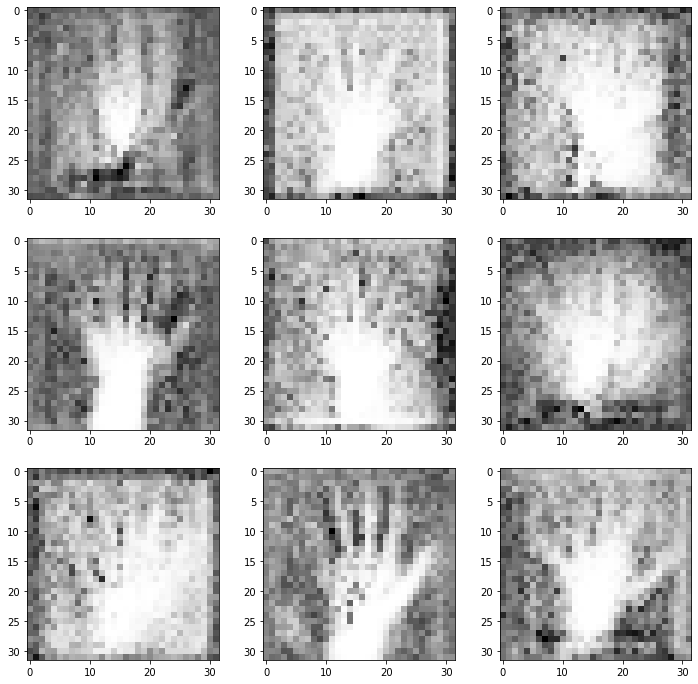

In [7]:
with torch.no_grad():
    generated = G(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
print(f"These are the images for epoch {epoch}")

This was my initial model, really simple just to make sure everything was working. However, after 3000 epochs, it was still much worse than expected so I decided to completely overhaul my architecture with another named DCGAN that I found online.

## DCGAN

In [8]:
test_z = torch.randn(100, z_dim).to(device)
# generated = G(test_z)


In [9]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
epoch=250
G_2 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_2.load_state_dict(torch.load(f"./models (DCGAN NO INIT)/drive-download-20231208T104045Z-001/Generator_{epoch:03d}.pth"))
G_2


Generator_2(
  (relu): ReLU()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

These are the images for epoch 250


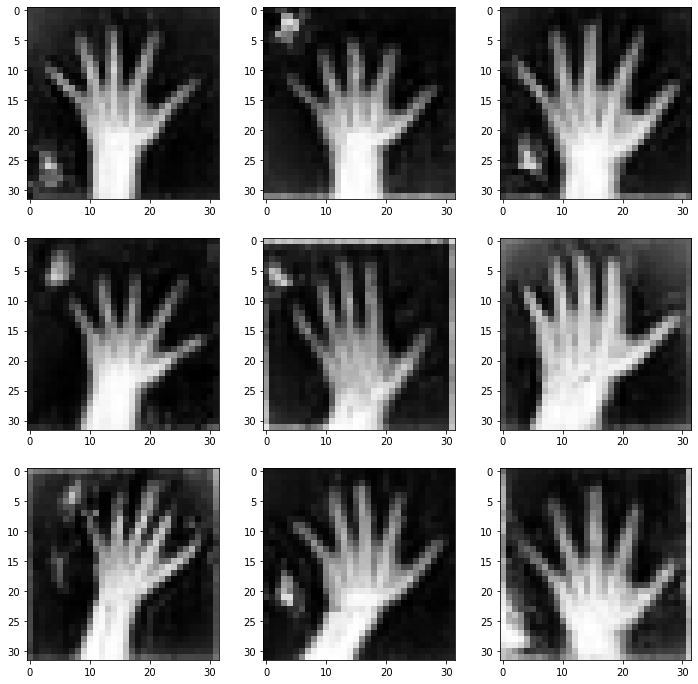

In [10]:
with torch.no_grad():
    generated = G_2(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
print(f"These are the images for epoch {epoch}")

As expected, the more complex model with convolutional layers performs much better with many fewer epochs. The DCGAN architecture recommends that we initialise our weights, so I added weight initialisation to see what it does to the images. 

As this training was done overnight, I also decided to train multiple different lrs with the weigt initialisation structure recomended

## Weight initialisation 

### lr = 0.0002

In [11]:
epoch=250
G_3 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_3.load_state_dict(torch.load(f"./models/DCGAN (WINIT)/Generator_{epoch:03d}.pth"))
G_3


Generator_2(
  (relu): ReLU()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

These are the images for epoch 250


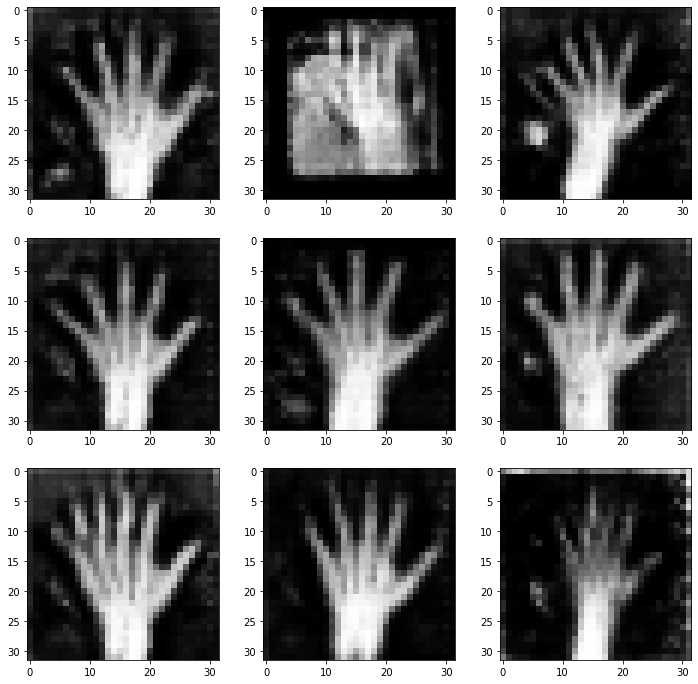

In [12]:
with torch.no_grad():
    generated = G_3(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
print(f"These are the images for epoch {epoch}")

### lr = 0.00008

In [13]:
epoch=325
G_4 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_4.load_state_dict(torch.load(f"./models/dc_init_lr_low/Generator_{epoch:03d}.pth"))
G_4


Generator_2(
  (relu): ReLU()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

These are the images for epoch 325


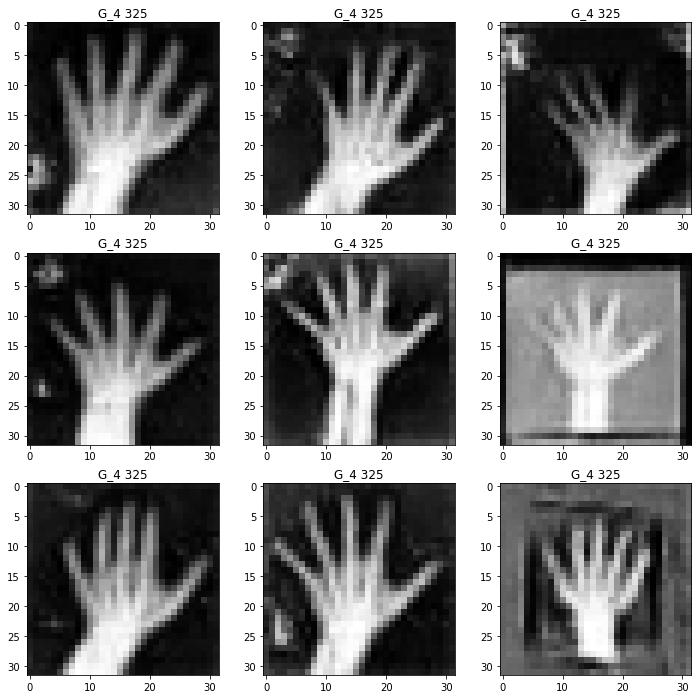

In [14]:
with torch.no_grad():
    generated = G_4(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.set_title(f"G_4 {epoch}")
    ax.imshow(img, cmap="gray")
print(f"These are the images for epoch {epoch}")

### lr = 0.0008

In [15]:
epoch=300
G_5 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_5.load_state_dict(torch.load(f"./models/dc_init_lr_high/Generator_{epoch:03d}.pth"))
G_5


Generator_2(
  (relu): ReLU()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

These are the images for epoch 300


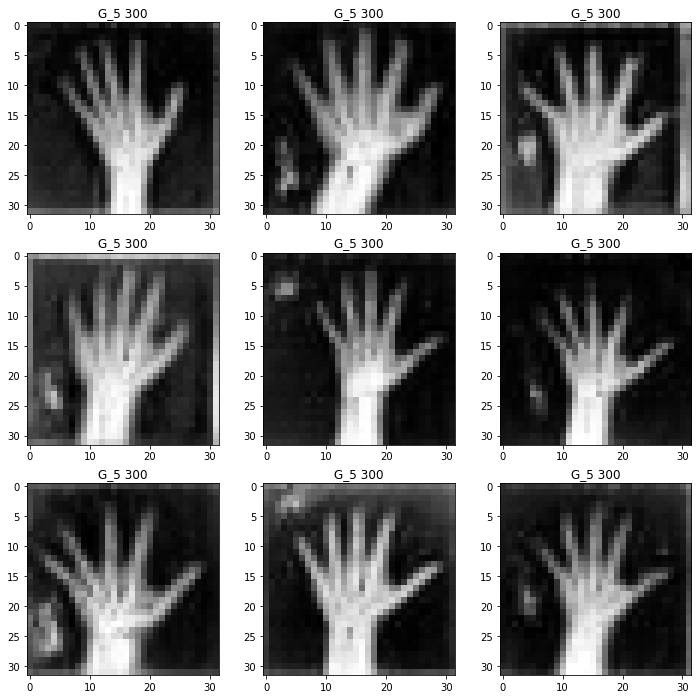

In [16]:
with torch.no_grad():
    generated = G_5(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.set_title(f"G_5 {epoch}")
    ax.imshow(img, cmap="gray")
print(f"These are the images for epoch {epoch}")

### lr = 0.002

In [17]:
epoch=250
G_6 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_6.load_state_dict(torch.load(f"./models/dc_init_lr_v_high/Generator_{epoch:03d}.pth"))
G_6


Generator_2(
  (relu): ReLU()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

These are the images for epoch 250


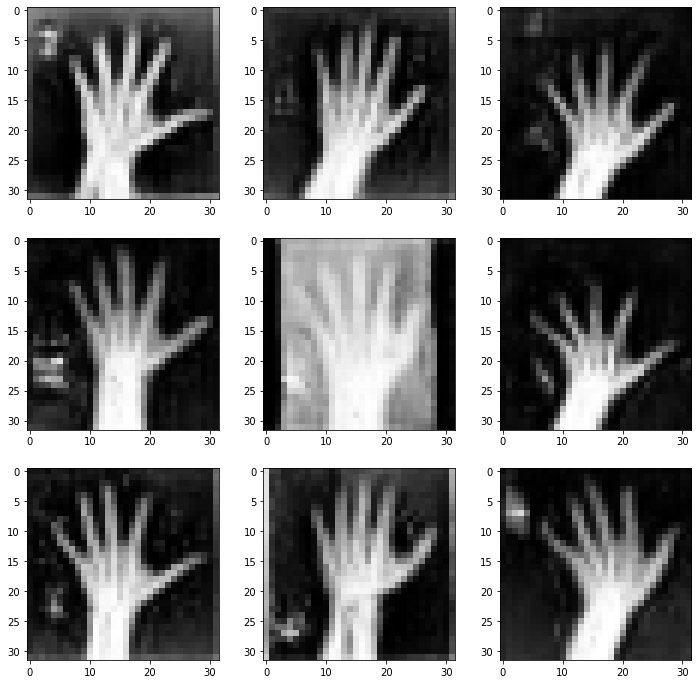

In [18]:
with torch.no_grad():
    generated = G_6(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
print(f"These are the images for epoch {epoch}")

and after 325 epochs: 

## lr = 0.0008 (325 Epochs)

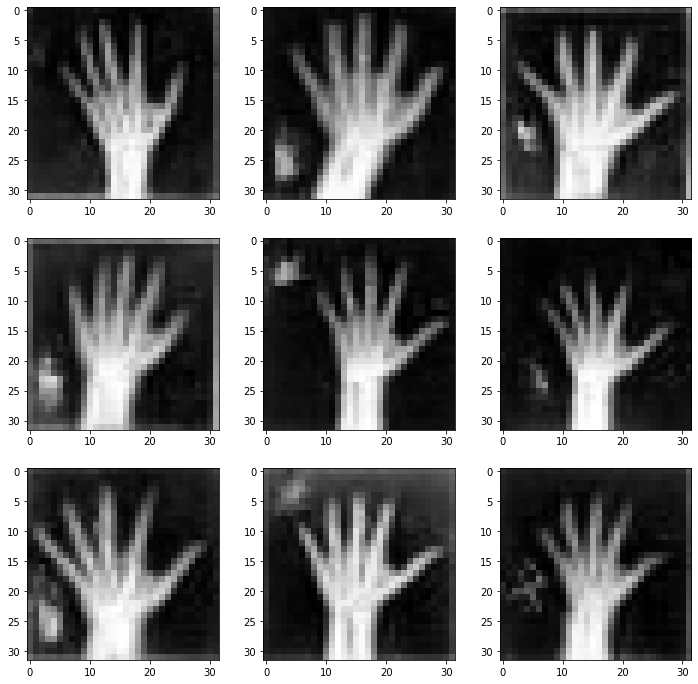

In [19]:
epoch=325
G_7 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_7.load_state_dict(torch.load(f"./models/dc_init_lr_high/Generator_{epoch:03d}.pth"))
G_7

with torch.no_grad():
    generated = G_7(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")


## lr = 0.00008 (325 epochs)

These are the images for epoch 325


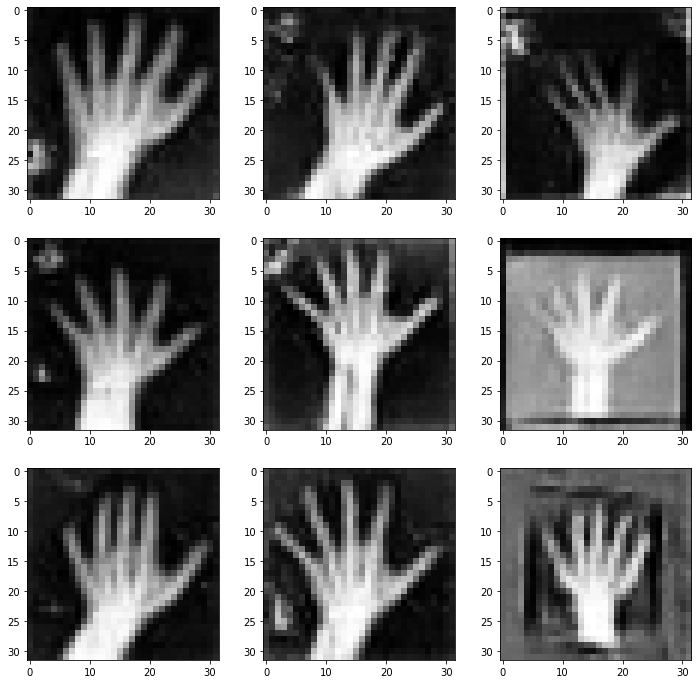

In [20]:
epoch=325
G_8 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_8.load_state_dict(torch.load(f"./models/dc_init_lr_low/Generator_{epoch:03d}.pth"))
G_8

with torch.no_grad():
    generated = G_8(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
print(f"These are the images for epoch {epoch}")

Fortunately I tried multiple lrs as some were worse with weight initialisation. After the specified 250 epochs The DCGANs with weight initialisation were both good but there was no clear winner, so i decided to let them train a little bit longer and I found that the lr of lr = 0.00008 was the better one. 

I was now ready to try adding a beta parameter to my model.

## beta

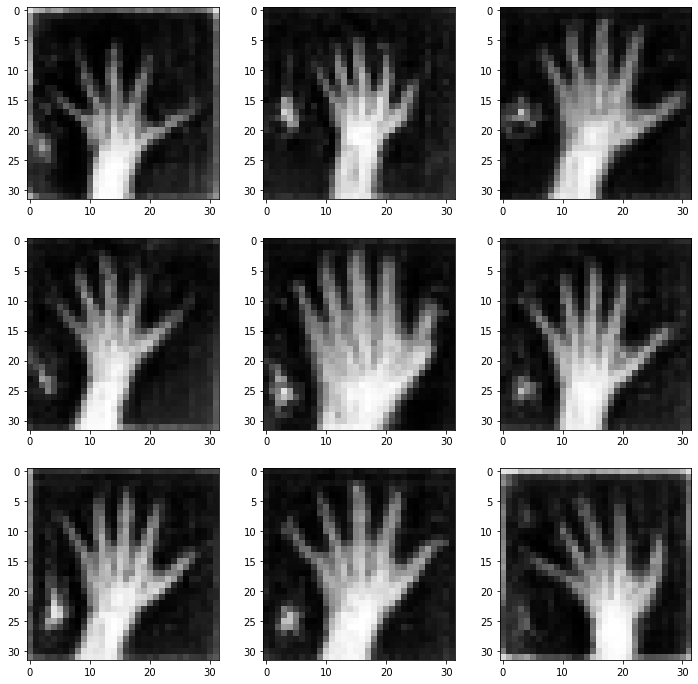

In [21]:
epoch=1000
G_9 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_9.load_state_dict(torch.load(f"./models/beta_mhlr/Generator_{epoch:03d}.pth"))
G_9

with torch.no_grad():
    generated = G_9(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")


Because of the difficulties I had with choosing a superior model, I decided to use a trained discriminator and calculate how many times generators could fool the discriminator. 

In reality, discriminators are just trained to not be fooled by the Generator, and not to explicitly detect "real" images, it is still able to provide some help especially when I'm not sure which direction to go in. For this reason, I wont be using a discriminator to evaluate its corresponding generator, as the 2 may be biased (The Generator may just be good at fooling its discriminator rather than generating realistic images). I will also only use this metric as guidance rather than strictly following it. 


In [22]:
epoch=175
D = Discriminator(ngpu=1,ndf=ndf,nc = 1).cuda()
D.load_state_dict(torch.load(f"./models/DCGAN (WINIT)/Discriminator_{epoch:03d}.pth"))

<All keys matched successfully>

I would like to test `amsgrad` with Adam. After 325 epochs i still struggle to fool my sample discriminator. `amsgrad=True` might help the model converge to better solutions at such a late epoch.

These are the images for epoch 325


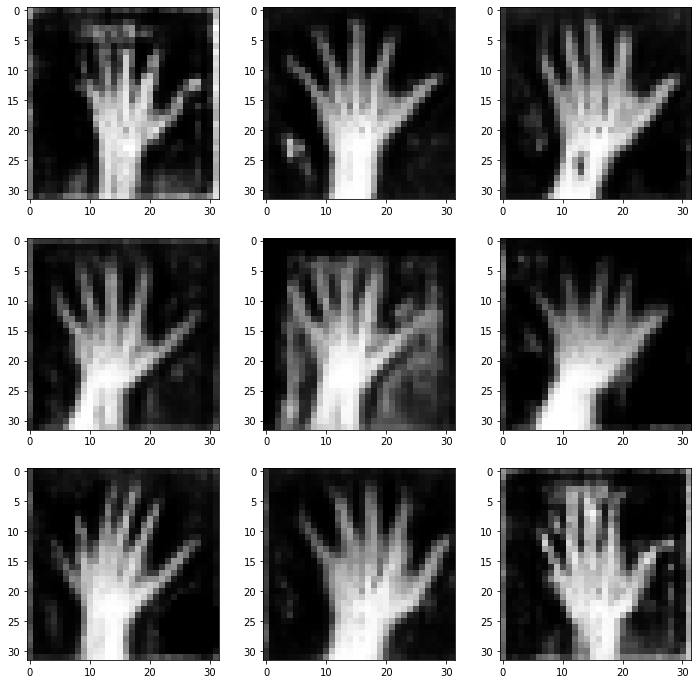

In [23]:
epoch=325
G_10 = Generator_2(ngpu=1, nz = 100,ngf = 64,nc = 1).cuda()
G_10.load_state_dict(torch.load(f"./models/amsgrad/Generator_{epoch:03d}.pth"))
G_10

with torch.no_grad():
    generated = G_10(test_z).to(device)

fig, axarr = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
print(f"These are the images for epoch {epoch}")

In [25]:
with torch.no_grad():
    discriminated_7 = D(G_7(test_z).to(device)).to(device)
    discriminated_8 = D(G_8(test_z).to(device)).to(device)
    discriminated_9 = D(G_9(test_z).to(device)).to(device)
    discriminated_10 = D(G_8(test_z).to(device)).to(device)

print(f"The high lr model fools the discriminator {torch.mean(torch.round(discriminated_7))}% of the time")
print(f"The low lr model fools the discriminator {torch.mean(torch.round(discriminated_8))}% of the time")
print(f"The beta model fools the discriminator {torch.mean(torch.round(discriminated_9))}% of the time")
print(f"The amsgrad mdoel fools the discriminator {torch.mean(torch.round(discriminated_10))}% of the time")


The high lr model fools the discriminator 0.550000011920929% of the time
The low lr model fools the discriminator 0.5899999737739563% of the time
The beta model fools the discriminator 0.05999999865889549% of the time
The amsgrad mdoel fools the discriminator 0.5899999737739563% of the time


Amsgrad visually makes the model worse, and also fails to fool the discriminator even once so i wont be using that.

While using the recomended beta doesnt ruin harm the performance against my discriminator, it visually makes the outputs look worse, so i will not use it.

Overall balancing visuals and the score, the high lr model does the best and that is what i will choose.

### With this we have my final architecture: 
1. A Deep Convolution GAN, 
2. With an `lr=0.0008` 
3. weight initialisation
4. default_values for `beta` due to experimentation
5. `amsgrad=False` due to experimentation
6. No change in the latent dimension size due to clearly visible variation in my outputs